In [6]:
from numba import jit
import numpy as np
import matplotlib.pyplot as plt
import time

N=128      # Numero de cidades

rng = np.random.default_rng(seed=42)   # Define as posições aleatórias das cidades
x=rng.random(N)
y=rng.random(N)

# define o caminho que liga as cidades (inicialmente a sequencia como foi criada)
pathini = np.zeros(N,dtype=np.int16)
for i in range(N):
    pathini[i]=i
# Tempo FInal

In [7]:
#define a distancia entre duas cidades quaisquer
@jit(nopython=True)
def distances(N,x,y):
    
    dist = np.zeros((N,N),dtype=np.float32)
    for i in range(N):
        for j in range(N):
            dist[i,j] = np.sqrt((x[i]-x[j])*(x[i]-x[j])+(y[i]-y[j])*(y[i]-y[j]))
            
    return dist

In [8]:
@jit(nopython=True)
def custo(N,path,dist):
    # calcula a distancia total percorrida pela caminhada
    ener = 0
    for i in range(N-1):
        ener += dist[path[i],path[i+1]]
    ener += dist[path[0],path[N-1]]     # conecta a última e a primeira cidades do caminho
    
    return ener

In [9]:
@jit(nopython=True)
def newpath(N,path):
    
    # define uma nova caminhada
    
    newpath = np.zeros(N,dtype=np.int16)

    i=np.random.randint(N)   # escolhe uma posição aleatória da caminhada
    j=i
    while j==i:
        j=np.random.randint(N)  # escolhe outra posição 
    if i>j:                    # ordena os índices
        ini = j
        fin = i
    else:
        ini = i
        fin = j

    for k in range(N):        # inverte o sentido em que percorre o caminho entre os indices escolhidos
        if k >= ini and k <= fin:
            newpath[k] = path[fin-k+ini]
        else:
            newpath[k] = path[k]

    return newpath,ini,fin



In [10]:
@jit(nopython=True)
def mcstep(N,beta,en,path,best_e,best_p,dist):
    # realiza um passo de Monte Carlo
    np1 = np.zeros(N,dtype=np.int16)
    
    np1,ini,fin = newpath(N,path) # propoe um novo caminho
    
    # determina a diferença de energia 
    esq = ini-1         # cidade anterior a inicial
    if esq < 0: esq=N-1      # condicao de contorno
    dir = fin +1        # cidade apos a final
    if dir > N-1: dir=0      # condicao de contorno
    de = -dist[path[esq],path[ini]] - dist[path[dir],path[fin]]+ dist[np1[esq],np1[ini]] + dist[np1[dir],np1[fin]]

    if de < 0:         # aplica o criterio de Metropolis
        en += de
        path = np1
        if en < best_e:  # guarda o melhor caminho gerado até o momento
            best_e = en
            best_p = path
    else:              # aplica o criterio de Metropolis
        if np.random.random() < np.exp(-beta*de):
            en += de
            path = np1
            
    return en,path,best_e,best_p

In [27]:
@jit(nopython=True)
def execution(decrease_rate, begin_temperature, end_temperature, passos_de_monte_carlo, N, begin_path, x, y, n_restart):
    temperature = begin_temperature
    distance = distances(N, x, y)
    energy = custo(N, begin_path, distance)
    path = begin_path

    
    best_energy = energy
    best_path = begin_path
    
    count_restart_high_temp = n_restart
    count_restart_low_temp = n_restart
    count_do_again = n_restart
    while(temperature > end_temperature):

        for i in range(passos_de_monte_carlo):
            energy, path, best_energy, best_path = mcstep(N, 1 / temperature, energy, path, best_energy, best_path, distance)
        
        temperature *= decrease_rate
        

        # Os if's abaixo são responsáveis pelo restart ou seja responsável por aumentar a energia do sistema
        # Para que o mesmo aceite mudanças mais drasticas
        if count_restart_high_temp != 0 and temperature < begin_temperature * 0.5:
            temperature = begin_temperature * 1
            count_restart_high_temp -= 1 

        if count_restart_high_temp == 0 and count_restart_low_temp != 0 and temperature < begin_temperature * 0.01:
            temperature = begin_temperature * 0.4
            count_restart_low_temp -= 1 

        if temperature > end_temperature and count_do_again:
            temperature = begin_temperature
            count_do_again -= 1
            count_restart_high_temp = n_restart
            count_restart_low_temp = n_restart

        

    return best_path, best_energy

In [12]:
rng = np.random.default_rng(seed=42)

## Dados dado pelo Professor

In [33]:
file = open('arquivo_de_entrada/prof_example.dat')

location = []

for line in file:
    x, y = line.split(" ")
    x = float(x)
    y = float(y)
    location.append([x, y])

location = np.asarray(location)

x = location[:, 0]
y = location[:, 1]
N = x.size

pathini = np.zeros(N,dtype=np.int16)
for i in range(N):
    pathini[i]=i

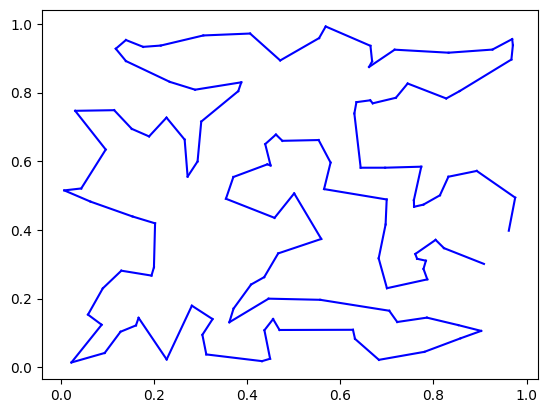

In [34]:
caminho, distacia = execution(0.99, 10, 0.0001, 500, N,pathini, x, y, n_restart=0)

for cidade in range (len(caminho) - 1):
    plt.plot([x[caminho[cidade]], x[caminho[cidade+1]]],[y[caminho[cidade]], y[caminho[cidade+1]]], 'b')

In [32]:
distacia

8.495340194553137

# Possições passadas pelo Professor

In [17]:
prof_x = np.asarray([
    7.739560485559633385e-01, 
    4.388784397520523184e-01, 
    8.585979199113824567e-01, 
    6.973680290593639031e-01, 
    9.417734788764953180e-02, 
    9.756223516367559245e-01, 
    7.611397019903529682e-01, 
    7.860643052769538119e-01, 
    1.281136326755458743e-01, 
    4.503859378955671344e-01, 
    3.707980242325812359e-01, 
    9.267649888486018117e-01, 
    6.438651200806645436e-01, 
    8.227616132708299723e-01, 
    4.434141988273311297e-01, 
    2.272387217847768870e-01, 
    5.545847870158348014e-01, 
    6.381725610417532391e-02, 
    8.276311719925820709e-01, 
    6.316643991220648457e-01, 
    7.580877400853738290e-01, 
    3.545259681298683629e-01, 
    9.706980243949032694e-01, 
    8.931211213221976752e-01, 
    7.783834970737618653e-01, 
    1.946387078519675740e-01, 
    4.667210037270341783e-01, 
    4.380376578722877667e-02, 
    1.542894920675478287e-01, 
    6.830489532424546262e-01, 
    7.447621559078171360e-01, 
    9.675097324342100125e-01, 
    3.258253581381519437e-01, 
    3.704597060348688853e-01, 
    4.695558112758079217e-01, 
    1.894713590842856954e-01, 
    1.299215053354716431e-01, 
    4.757049262259337441e-01, 
    2.269093490508841127e-01, 
    6.698139946825103497e-01, 
    4.371519188723307359e-01, 
    8.326781960578374386e-01, 
    7.002651020022491180e-01, 
    3.123666413820410659e-01, 
    8.322598013952010598e-01, 
    8.047643574968018632e-01, 
    3.874783790301744579e-01, 
    2.883281039302441062e-01, 
    6.824955039749754926e-01, 
    1.397524836093098077e-01, 
    1.999082024751083209e-01, 
    7.362269751005512397e-03, 
    7.869243775021383946e-01, 
    6.648508565920321356e-01, 
    7.051653786263351043e-01, 
    7.807290310219678897e-01, 
    4.589157755383399540e-01, 
    5.687411959528937411e-01, 
    1.397969981276574458e-01, 
    1.145300735359734423e-01, 
    6.684029617904716503e-01, 
    4.710962061431325232e-01, 
    5.652361064811888269e-01, 
    7.649988574160255794e-01, 
    6.347183200005908077e-01, 
    5.535794006579958237e-01, 
    5.592071607454135451e-01, 
    3.039500980626121951e-01, 
    3.081783456793940612e-02, 
    4.367173892323623630e-01, 
    2.145846728195291986e-01, 
    4.085286437246361535e-01, 
    8.534030732681661124e-01, 
    2.339394858653407461e-01, 
    5.830274168906601773e-02, 
    2.813838920219965400e-01, 
    2.935937577666836162e-01, 
    6.619165147268950555e-01, 
    5.570321523412783415e-01, 
    7.838982091064135016e-01, 
    6.643135403273875417e-01, 
    4.063868614400705237e-01, 
    8.140203846660346576e-01, 
    1.669729199077039095e-01, 
    2.271207313386047755e-02, 
    9.004786077564175262e-02, 
    7.223593505964502892e-01, 
    4.618772302513873829e-01, 
    1.612717790336017920e-01, 
    5.010447751033635377e-01, 
    1.523121027131684180e-01, 
    6.963203750777360312e-01, 
    4.461562755740307029e-01, 
    3.810212260964824793e-01, 
    3.015120891478765275e-01, 
    6.302825931188884567e-01, 
    3.618126105533904235e-01, 
    8.764991931610099929e-02, 
    1.180059021205153158e-01, 
    9.618976645495145306e-01, 
    9.085806907076070527e-01, 
    6.997071338107495597e-01, 
    2.658699614595195770e-01, 
    9.691763773477238830e-01, 
    7.787509039657946053e-01, 
    7.168901891589956055e-01, 
    4.493615021437886714e-01, 
    2.722415618451590191e-01, 
    9.639096215349929331e-02, 
    9.026023965438416674e-01, 
    4.557762898336110702e-01, 
    2.023633647952303161e-01, 
    3.059566241506525008e-01, 
    5.792195689418959681e-01, 
    1.767727829392317096e-01, 
    8.566142840923754997e-01, 
    7.585195298352100934e-01, 
    7.194629559509367889e-01, 
    4.320930397751037155e-01, 
    6.273088407024431934e-01, 
])

In [18]:
prof_y = np.asarray([
    5.840979689127355767e-01,
    6.498466015548199914e-01,
    8.444432113988908917e-02,
    4.158074021706096302e-01,
    4.161417386189247836e-02,
    4.939908192445189306e-01,
    3.298612123327853141e-01,
    1.445241888660468987e-01,
    1.034029677225516419e-01,
    5.876445721777120434e-01,
    1.705929685368861026e-01,
    9.251201183767971958e-01,
    5.810611397003949685e-01,
    3.468698045348370673e-01,
    5.909154914814167547e-01,
    2.280387102969749780e-02,
    9.585592132414453292e-01,
    4.823034369429002322e-01,
    7.827352272502862141e-01,
    8.272999992243856848e-02,
    4.866583308381603468e-01,
    4.907069943545209201e-01,
    9.378264549749828483e-01,
    5.717280523760753796e-01,
    4.734894010569538070e-01,
    2.669756630918935780e-01,
    3.315689973425521853e-01,
    5.206724024715377874e-01,
    4.389114603050466856e-01,
    2.161207988033042593e-02,
    8.262919241943578186e-01,
    8.961607718397667233e-01,
    1.402490889986107714e-01,
    5.540361435390493972e-01,
    1.085757411354435487e-01,
    6.722400930398116925e-01,
    2.812337838390083222e-01,
    6.594226346919017656e-01,
    7.269946142868826122e-01,
    7.686474919176570220e-01,
    1.077409459558965610e-01,
    9.160118451376079163e-01,
    2.302139908948808156e-01,
    3.741255617617977869e-02,
    5.548524693914833605e-01,
    3.709222838624387508e-01,
    8.297897431324131601e-01,
    8.082514720643018125e-01,
    3.171388928227153459e-01,
    9.528993950697449700e-01,
    2.909178381401186231e-01,
    5.150571292317145389e-01,
    2.559650905676027488e-01,
    9.360435700489633248e-01,
    1.646078175820181455e-01,
    4.491061939232898759e-02,
    4.350970600030379387e-01,
    9.923755640558370450e-01,
    8.916772662549139472e-01,
    7.486080194569492141e-01,
    8.907924908785248563e-01,
    8.934466396978631986e-01,
    5.188583603864490579e-01,
    3.159290518307930062e-01,
    7.720124321109880228e-01,
    6.616612631677610823e-01,
    3.736577288737100710e-01,
    9.446666806151526874e-02,
    7.467896113490259946e-01,
    2.624605159228646789e-01,
    9.368131505337792264e-01,
    2.409705750056847506e-01,
    1.227579324114860260e-01,
    8.311126721249061378e-01,
    1.532843166244940436e-01,
    1.792683081577390869e-01,
    5.993827915208435053e-01,
    8.745620408374644716e-01,
    1.964346657145732422e-01,
    3.103236729000947713e-01,
    7.774048382411775648e-01,
    9.718264260609673633e-01,
    5.007411862023423144e-01,
    1.438975025512507777e-01,
    1.393628770820154461e-02,
    2.296560299988552600e-01,
    1.318222177865210343e-01,
    6.776586736128574762e-01,
    1.218325046285311242e-01,
    5.063299316206330003e-01,
    6.942624356428864774e-01,
    5.811166092209023581e-01,
    1.997756516600576182e-01,
    8.041245261822627111e-01,
    7.154071296158016624e-01,
    7.389840039155417539e-01,
    1.310577515573132512e-01,
    1.237538036503446071e-01,
    9.275625510065076407e-01,
    3.975781938249406400e-01,
    3.009486917809397477e-01,
    4.885840453515333248e-01,
    6.628642127635824277e-01,
    9.556232570469699317e-01,
    2.864462268820550106e-01,
    9.248084293120271138e-01,
    2.485949138625631605e-02,
    5.551980423268246811e-01,
    6.339751116810851128e-01,
    1.058974037507532939e-01,
    1.403395970639126356e-01,
    4.191143193163038294e-01,
    9.662319121431817148e-01,
    5.960425532343728294e-01,
    9.330232216002112278e-01,
    8.043609156129707394e-01,
    4.673816015552915148e-01,
    7.847634492521874394e-01,
    1.783678397698773566e-02,
    1.091439967657349408e-01
])